In [1]:
from tdmclient import ClientAsync
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

In [2]:
from threading import Timer

class RepeatedTimer(object):
    def __init__(self, interval, function, *args, **kwargs):
        self._timer     = None
        self.interval   = interval
        self.function   = function
        self.args       = args
        self.kwargs     = kwargs
        self.is_running = False
        self.start()

    def _run(self):
        self.is_running = False
        self.start()
        self.function(*self.args, **self.kwargs)

    def start(self):
        if not self.is_running:
            self._timer = Timer(self.interval, self._run)
            self._timer.start()
            self.is_running = True

    def stop(self):
        self._timer.cancel()
        self.is_running = False

In [18]:
Ts = 0.1
thymio_data = []

def motors(left, right):
    return {
        "motor.left.target": [left],
        "motor.right.target": [right],
    }

def get_data():
    thymio_data.append({"ground":list(node["prox.ground.reflected"]), 
                        "sensor":list(node["prox.ground.reflected"]),
                        "left_speed":node["motor.left.speed"],
                        "right_speed":node["motor.right.speed"],
                        "acc":list(node["acc"])})
    


await node.wait_for_variables() # wait for Thymio variables values
rt = RepeatedTimer(Ts, get_data) # it auto-starts, no need of rt.start()
i=0
motor_targets = [[50,50],[100,100],[150,150],[200,200],[-200,-200], [-150,-150], [-100,-100],[50,-50], [-50,50], [100,0], [0,100]]
while(i < len(motor_targets)):
        # time.sleep would not work here, use asynchronous client.sleep method instead
        ul,ur = motor_targets[i]
        node.send_set_variables(motors(ul,ur))
        await client.sleep(10) # your long-running job goes here...
        i += 1

rt.stop() # better in a try/finally block to make sure the program ends!
node.send_set_variables(motors(0, 0))

CancelledError: 

In [15]:
len(motor_targets)

4

In [4]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np
from tqdm import tqdm

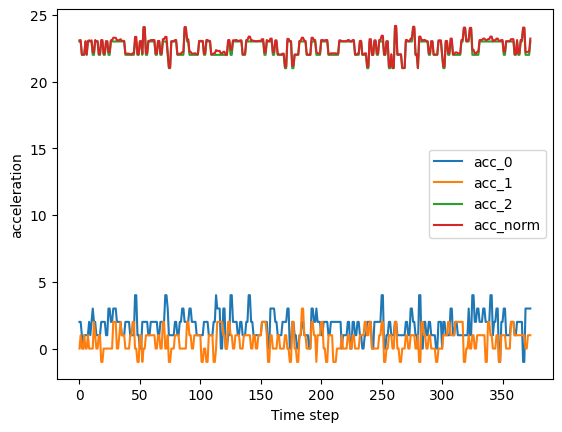

In [8]:
acc_0 = np.array([x["acc"][0] for x in thymio_data])
acc_1 = np.array([x["acc"][1] for x in thymio_data])
acc_2 = np.array([x["acc"][2] for x in thymio_data])
acc_norm = np.sqrt(acc_0**2 + acc_1**2 + acc_2**2)

plt.plot(acc_0, label="acc_0")
plt.plot(acc_1, label="acc_1")
plt.plot(acc_2, label="acc_2")
plt.plot(acc_norm, label="acc_norm")


plt.xlabel("Time step")
plt.ylabel("acceleration")
plt.legend()

In [ ]:
l_peaks = find_peaks(l_sensor, 610, 10)[0]

plt.plot(acc_0, label="left sensor")
plt.plot(r_sensor, label="right sensor")
plt.plot(l_peaks, [l_sensor[idx] for idx in l_peaks], "o", label = "left sensor peaks")
plt.xlabel("Time step")
plt.ylabel("Ground sensor measurement")
plt.legend()

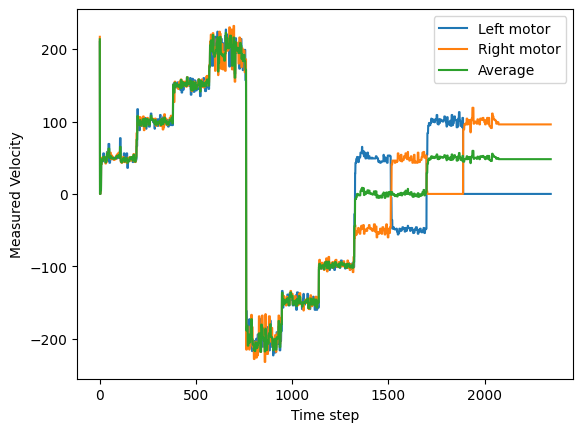

In [17]:
l_speed = [x["left_speed"] for x in thymio_data]
r_speed = [x["right_speed"] for x in thymio_data]
avg_speed = [(x["left_speed"]+x["right_speed"])/2 for x in thymio_data]
plt.plot(l_speed, label="Left motor")
plt.plot(r_speed, label="Right motor")
plt.plot(avg_speed, label="Average")
plt.xlabel("Time step")
plt.ylabel("Measured Velocity")
plt.legend()

In [12]:
mean_l_speed = np.mean(l_speed[25:])
mean_r_speed = np.mean(r_speed[25:])
var_l_speed = np.var(l_speed[25:]) # took from 55 to avoid the initial transient and devid by the conversion factor
var_r_speed = np.var(r_speed[25:])
print(f"mean_l_speed={mean_l_speed}")
print(f"mean_r_speed={mean_r_speed}")
print(f"var_l_speed={var_l_speed}")
print(f"var_r_speed={var_r_speed}")

mean_l_speed=99.58166189111748
mean_r_speed=99.57593123209169
var_l_speed=43.3493485275162
var_r_speed=16.931913531087595


In [19]:
await node.unlock()

In [20]:
await node.lock()
node.send_set_variables(motors(0,0))